In [1]:
import os
import hashlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    LassoCV,
    RidgeCV,
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

In [2]:
RANDOM_STATE = 42

In [3]:
def hash_columns(columns):
    col_str = ",".join(sorted(columns))
    return hashlib.sha256(col_str.encode()).hexdigest()

In [4]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [5]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [6]:
def check_signature(expected, actual):
    # print(actual)
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [7]:
def test_func(func, signature):
    df = pd.read_csv("agriculture-test.csv")
    df = func(df)
    check_signature(signature, hash_data_frame(df))

In [8]:
def test_partition(func, train_X_signature, test_X_signature, train_y_signature, test_y_signature):
    df = pd.read_csv("agriculture-test.csv")
    train_X, test_X, train_y, test_y = func(df)
    try:
        # print(hash_data_frame(train_X))
        # print(hash_data_frame(test_X))
        # print(hash_series(train_y))
        # print(hash_series(test_y))
        assert hash_data_frame(train_X) == train_X_signature
        assert hash_data_frame(test_X) == test_X_signature
        assert hash_series(train_y) == train_y_signature
        assert hash_series(test_y) == test_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [9]:
def test_normalize(func, train_X_signature, test_X_signature):
    df = pd.read_csv("agriculture-test.csv")
    train_X, test_X = func(df[:80][["soil_temperature", "soil_nitrogen"]], df[80:100][["soil_temperature", "soil_nitrogen"]])
    try:
        # print(hash_data_frame(pd.DataFrame(train_X)))
        # print(hash_data_frame(pd.DataFrame(test_X)))
        assert hash_data_frame(pd.DataFrame(train_X)) == train_X_signature
        assert hash_data_frame(pd.DataFrame(test_X)) == test_X_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [10]:
def test_model(func, pred_y_signature):
    df = pd.read_csv("agriculture-test.csv").dropna(axis=0)
    model = func(df[:2000][["soil_moisture_index", "soil_health_index"]], df[:2000]["disease_severity"])
    model = func(train_X, train_y)
    pred_y = model.predict(train_X)
    try:
        # print(hash_series(pd.Series(pred_y)))
        assert hash_series(pd.Series(pred_y)) == pred_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [11]:
def test_evaluation(precision, recall, f1):
    try:
        assert precision > 0.70
        assert recall > 0.70
        assert f1 > 0.70
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [12]:
df = pd.read_csv("agriculture.csv")

In [13]:
df.head()

,device_info,sensor_packet,sunlight_hours,soil_moisture_index,soil_health_index,irrigation_type,region,crop_variety,growth_stage,disease_severity,certification_level,yield_category
0,DEV-5026,T=13.40|N=6.97|H=58.2,1.388465,4.955898,2.807322,drip,North,Var_30,Vegetative,NaN,ISO9001,Low
1,NODE-9949,T=21.51|N=11.74|H=50.6,3.192327,3.262310,2.938019,sprinkler,South,Var_39,Seedling,No Disease,ISO9001,High
2,DEV-9932,T=27.39|N=11.14|H=58.2,2.477811,2.128176,2.295340,sprinkler,South,Var_18,Flowering,NaN,ISO9001,Medium
3,DEV-4437,T=18.97|N=8.57|H=47.3,4.197804,2.511680,1.941526,drip,South,Var_22,Flowering,No Disease,ISO9001,Low
4,DEV-9581,T=21.80|N=10.15|H=48.6,4.758862,3.436560,NaN,drip,East,Var_27,Vegetative,No Disease,ISO9001,High


In [14]:
### MANUALLY GRADED TASK
def calculate_descriptive_statistics(df):
    """
    Calculate the descriptive statistics for all numeric variables in the dataset.
    The statistics should include: count, mean, standard deviation, minimum,
    25th percentile, median, 75th percentile, and maximum.
    
    Return the result as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    return df.describe()
    ### END SOLUTION

In [15]:
calculate_descriptive_statistics(df)

,sunlight_hours,soil_moisture_index,soil_health_index
count,9525.000000,9292.000000,9282.000000
mean,3.929670,4.129037,2.726327
std,1.976117,1.744594,1.106538
min,0.049477,0.779627,0.000000
25%,2.430703,2.903494,1.948743
50%,3.696851,3.788847,2.603356
75%,5.175118,4.943178,3.344840
max,12.143025,15.354022,10.000000


In [16]:
### MANUALLY GRADED TASK
def plot_sunlight_hours_distribution(df):
    """
    Plot the `sunlight_hours` distribution.
    """

    ### BEGIN SOLUTION
    sns.histplot(df, x="sunlight_hours")
    ### END SOLUTION

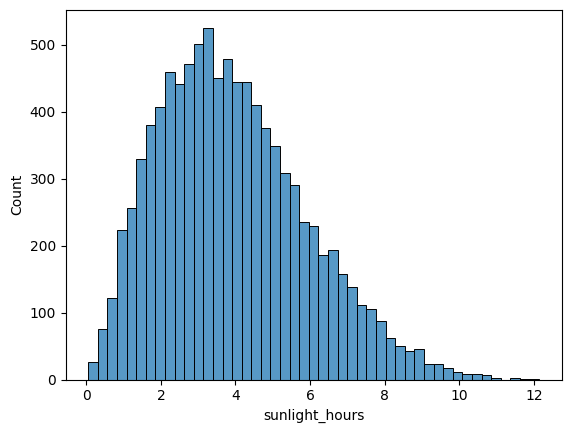

In [17]:
 plot_sunlight_hours_distribution(df)

In [18]:
### MANUALLY GRADED TASK
def plot_yield_category_distribution(df):
    """
    Plot the `yield_category` distribution.
    """

    ### BEGIN SOLUTION
    sns.barplot(df["yield_category"].value_counts())
    ### END SOLUTION

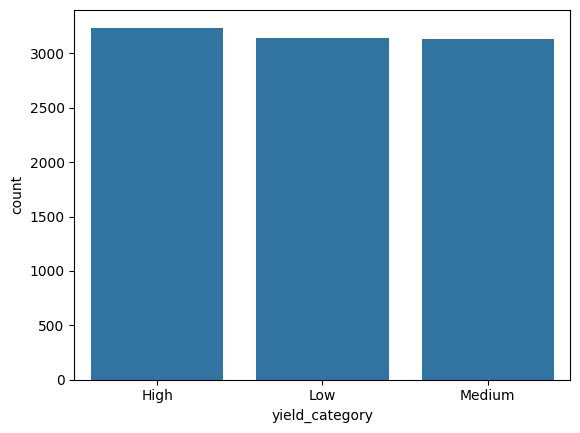

In [19]:
plot_yield_category_distribution(df)

In [20]:
### MANUALLY GRADED TASK
def plot_relationship_between_soil_moisture_index_and_soil_health_index(df):
    """
    Plot the relationship between `soil_moisture_index` and `soil_health_index`.
    """

    ### BEGIN SOLUTION
    sns.scatterplot(df, x="soil_moisture_index", y="soil_health_index")
    ### END SOLUTION

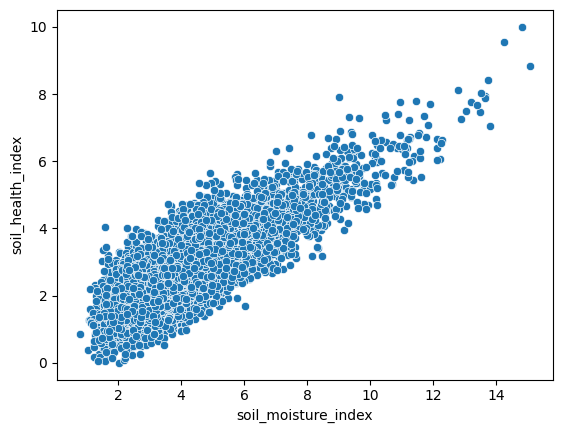

In [21]:
plot_relationship_between_soil_moisture_index_and_soil_health_index(df)

In [22]:
### MANUALLY GRADED TASK
def plot_soil_moisture_index_distribution_per_irrigation_type(df):
    """
    Plot the `soil_moisture_index` distribution per `irrigation_type`.
    """

    ### BEGIN SOLUTION
    sns.boxplot(df, x="irrigation_type", y="soil_moisture_index")
    ### END SOLUTION

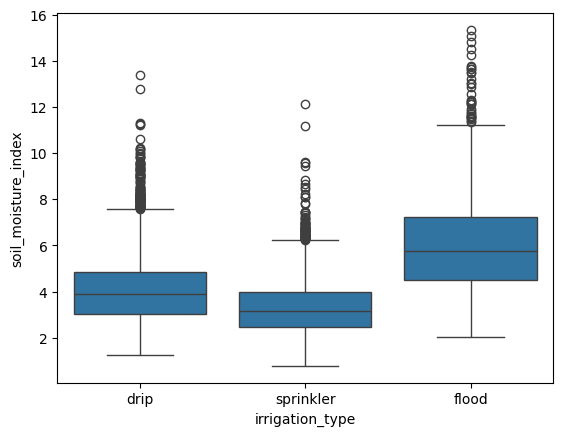

In [23]:
plot_soil_moisture_index_distribution_per_irrigation_type(df)

In [24]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_device_info(df):
    """
    Encode the `device_info` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["device_info"], inplace=True)
    ### END SOLUTION
    
    return df

In [25]:
df = encode_or_drop_device_info(df)

In [26]:
### TEST
test_func(encode_or_drop_device_info, "8ac49ac49cac0b8faeb7127e61d5fcdf079c2854631cb90c1279f8dc00607e7c")
### BEGIN HIDDEN TESTS
# df.to_csv("encode_or_drop_device_info.csv")
expected_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
initial_df = pd.read_csv("agriculture.csv")
actual_df = encode_or_drop_device_info(initial_df)
pd.testing.assert_frame_equal(expected_df, actual_df)
### END HIDDEN TESTS

✔ Test passed!


In [27]:
### AUTOMATICALLY GRADED TASK
def parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(df):
    """
    In the `sensor_packet` column, `T` stands for `soil_temperature` and `N` for `soil_nitrogen`.
    Parse the values for the `soil_temperature` from the `sensor_packet` column and add them as a new column named `soil_temperature`.
    Parse the values for the `soil_nitrogen` from the `sensor_packet` column and add them as a new column named `soil_nitrogen`.
    Then, remove the `sensor_packet` column from the dataset.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["soil_temperature"] = df["sensor_packet"].apply(lambda value: float(value.split("|")[0][2:]) if not pd.isna(value) else value)
    df["soil_nitrogen"] = df["sensor_packet"].apply(lambda value: float(value.split("|")[1][2:]) if not pd.isna(value) else value)
    df.drop(columns=["sensor_packet"], inplace=True)
    ### END SOLUTION
    
    return df

In [28]:
df = parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(df)

In [29]:
### TEST
test_func(parse_soil_temperature_and_soil_nitrogen_from_sensor_packet, "ba50e222cb35706e9cb52f2d433fd53ac73b1d2c2230d8269a0baff0aea9a65a")
### BEGIN HIDDEN TESTS
def test_parse_soil_temperature_and_soil_nitrogen_from_sensor_packet():
    # df.to_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv")
    expected_df = pd.read_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
    actual_df = parse_soil_temperature_and_soil_nitrogen_from_sensor_packet(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_parse_soil_temperature_and_soil_nitrogen_from_sensor_packet()
### END HIDDEN TESTS

✔ Test passed!


In [30]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_irrigation_type(df):
    """
    Encode the `irrigation_type` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["irrigation_type"])], axis=1)
    df.drop(columns=["irrigation_type"], inplace=True)
    ### END SOLUTION
    
    return df

In [31]:
df = encode_or_drop_irrigation_type(df)

In [32]:
### TEST
test_func(encode_or_drop_irrigation_type, "c74da4bacf1c8a6e754c689933f22d2201bd45451e478ff6199eb9190f1214c0")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_irrigation_type():
    # df.to_csv("encode_or_drop_irrigation_type.csv")
    expected_df = pd.read_csv("encode_or_drop_irrigation_type.csv", index_col=0)
    initial_df = pd.read_csv("parse_soil_temperature_and_soil_nitrogen_from_sensor_packet.csv", index_col=0)
    actual_df = encode_or_drop_irrigation_type(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_irrigation_type()
### END HIDDEN TESTS

✔ Test passed!


In [33]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_region(df):
    """
    Encode the `region` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["region"])], axis=1)
    df.drop(columns=["region"], inplace=True)
    ### END SOLUTION
    
    return df

In [34]:
df = encode_or_drop_region(df)

In [35]:
### TEST
test_func(encode_or_drop_region, "0cbb74e46f71e93de2e4aa0f7c7cd4ca31f132312d8748694718325d92ca12ac")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_region():
    # df.to_csv("encode_or_drop_region.csv")
    expected_df = pd.read_csv("encode_or_drop_region.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_irrigation_type.csv", index_col=0)
    actual_df = encode_or_drop_region(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_region()
### END HIDDEN TESTS

✔ Test passed!


In [36]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_crop_variety(df):
    """
    Encode the `crop_variety` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["crop_variety"], inplace=True)
    ### END SOLUTION
    
    return df

In [37]:
df = encode_or_drop_crop_variety(df)

In [38]:
### TEST
test_func(encode_or_drop_crop_variety, "aa2854a403fec7760b73a25e029d29139665ae84c97aac37e006601eb7aa1b11")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_crop_variety():
    # df.to_csv("encode_or_drop_crop_variety.csv")
    expected_df = pd.read_csv("encode_or_drop_crop_variety.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_region.csv", index_col=0)
    actual_df = encode_or_drop_crop_variety(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_crop_variety()
### END HIDDEN TESTS

✔ Test passed!


In [39]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_growth_stage(df):
    """
    Encode the `growth_stage` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["growth_stage"] = df["growth_stage"].map({"Seedling": 0, "Vegetative": 1, "Flowering": 2, "Maturity": 3})
    ### END SOLUTION
    
    return df

In [40]:
df = encode_or_drop_growth_stage(df)

In [41]:
### TEST
test_func(encode_or_drop_growth_stage, "c5a7d9ba2d46d7e7a19cb3a9c8a2969e2cf3161a351c3b0fbdde6c50905b6be2")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_growth_stage():
    # df.to_csv("encode_or_drop_growth_stage.csv")
    expected_df = pd.read_csv("encode_or_drop_growth_stage.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_crop_variety.csv", index_col=0)
    actual_df = encode_or_drop_growth_stage(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_growth_stage()
### END HIDDEN TESTS

✔ Test passed!


In [42]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_disease_severity(df):
    """
    Encode the `disease_severity` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["disease_severity"] = df["disease_severity"].map({"No Disease": 0, "Low": 1, "Medium": 2, "High": 3})
    ### END SOLUTION
    
    return df

In [43]:
df = encode_or_drop_disease_severity(df)

In [44]:
### TEST
test_func(encode_or_drop_disease_severity, "1a6b9a1e96e8873dce4c81514a668592eb414c21952cf48e7f9e9040ff283f9e")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_disease_severity():
    # df.to_csv("encode_or_drop_disease_severity.csv")
    expected_df = pd.read_csv("encode_or_drop_disease_severity.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_growth_stage.csv", index_col=0)
    actual_df = encode_or_drop_disease_severity(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_disease_severity()
### END HIDDEN TESTS

✔ Test passed!


In [45]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_certification_level(df):
    """
    Encode the `certification_level` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["certification_level"], inplace=True)
    ### END SOLUTION
    
    return df

In [46]:
df = encode_or_drop_certification_level(df)

In [47]:
### TEST
test_func(encode_or_drop_certification_level, "e09cb445333e11d7900153802f12b828dc76e419619091229cc5cc193e0084f8")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_certification_level():
    # df.to_csv("encode_or_drop_certification_level.csv")
    expected_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_disease_severity.csv", index_col=0)
    actual_df = encode_or_drop_certification_level(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_certification_level()
### END HIDDEN TESTS

✔ Test passed!


In [48]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_yield_category(df):
    """
    Encode the `yield_category` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["yield_category"] = df["yield_category"].map({"Low": 0, "Medium": 1, "High": 2})
    ### END SOLUTION
    
    return df

In [49]:
df = encode_or_drop_yield_category(df)

In [50]:
### TEST
test_func(encode_or_drop_yield_category, "9c81f50df87ba54eec4b47676bf393f620307833469717c92f41a4e3e45de4df")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_yield_category():
    # df.to_csv("encode_or_drop_yield_category.csv")
    expected_df = pd.read_csv("encode_or_drop_yield_category.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    actual_df = encode_or_drop_yield_category(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_yield_category()
### END HIDDEN TESTS

✔ Test passed!


In [51]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_sunlight_hours(df):
    """
    Impute or remove the missing values from the `sunlight_hours` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["sunlight_hours"]] = simple_imputer.fit_transform(df[["sunlight_hours"]])
    ### END SOLUTION
    
    return df

In [52]:
df = handle_missing_values_in_sunlight_hours(df)

In [53]:
### TEST
test_func(handle_missing_values_in_sunlight_hours, "55a1c22d142775db7302f471be900536d1416dadc7b3ba97fc8912820e49aadb")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_sunlight_hours():
    # df.to_csv("handle_missing_values_in_sunlight_hours.csv")
    expected_df = pd.read_csv("handle_missing_values_in_sunlight_hours.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_yield_category.csv", index_col=0)
    actual_df = handle_missing_values_in_sunlight_hours(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_sunlight_hours()
### END HIDDEN TESTS

✔ Test passed!


In [54]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_soil_temperature(df):
    """
    Impute or remove the missing values from the `soil_temperature` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["soil_temperature"]] = simple_imputer.fit_transform(df[["soil_temperature"]])
    ### END SOLUTION
    
    return df

In [55]:
df = handle_missing_values_in_soil_temperature(df)

In [56]:
### TEST
test_func(handle_missing_values_in_soil_temperature, "c5f28d8e48e5761a27f0b4ab36dc6fc6c78bd431afa5cdaa915449aad2f6bdcd")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_soil_temperature():
    # df.to_csv("handle_missing_values_in_soil_temperature.csv")
    expected_df = pd.read_csv("handle_missing_values_in_soil_temperature.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_sunlight_hours.csv", index_col=0)
    actual_df = handle_missing_values_in_soil_temperature(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_soil_temperature()
### END HIDDEN TESTS

✔ Test passed!


In [57]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_soil_nitrogen(df):
    """
    Impute or remove the missing values from the `soil_nitrogen` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["soil_nitrogen"]] = simple_imputer.fit_transform(df[["soil_nitrogen"]])
    ### END SOLUTION
    
    return df

In [58]:
df = handle_missing_values_in_soil_nitrogen(df)

In [59]:
### TEST
test_func(handle_missing_values_in_soil_nitrogen, "c5f28d8e48e5761a27f0b4ab36dc6fc6c78bd431afa5cdaa915449aad2f6bdcd")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_soil_nitrogen():
    # df.to_csv("handle_missing_values_in_soil_nitrogen.csv")
    expected_df = pd.read_csv("handle_missing_values_in_soil_nitrogen.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_soil_temperature.csv", index_col=0)
    actual_df = handle_missing_values_in_soil_nitrogen(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_soil_nitrogen()
### END HIDDEN TESTS

✔ Test passed!


In [60]:
### MANUALLY GRADED TASK
def handle_missing_values_in_soil_moisture_index_and_soil_health_index(df):
    """
    Impute or remove the missing values from the `soil_moisture_index` and `soil_health_index` columns.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    iterative_imputer = IterativeImputer()
    df[["soil_moisture_index", "soil_health_index"]] = iterative_imputer.fit_transform(df[["soil_moisture_index", "soil_health_index"]])
    ### END SOLUTION
    
    return df

In [61]:
df = handle_missing_values_in_soil_moisture_index_and_soil_health_index(df)
# df.to_csv("handle_missing_values_in_soil_moisture_index_and_soil_health_index.csv")

In [62]:
### MANUALLY GRADED TASK
def handle_missing_values_in_disease_severity(df):
    """
    Impute the missing values in the `disease_severity` column using `KNNImputer` with 5 neighbors.
    Use `soil_moisture_index` and `soil_health_index` for imputation.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    knn_imputer = KNNImputer(n_neighbors=5)
    df[["disease_severity", "soil_moisture_index", "soil_health_index"]] = knn_imputer.fit_transform(df[["disease_severity", "soil_moisture_index", "soil_health_index"]])
    df["disease_severity"] = df["disease_severity"].round()
    ### END SOLUTION
    
    return df

In [63]:
df = handle_missing_values_in_disease_severity(df)
# df.to_csv("handle_missing_values_in_disease_severity.csv")

In [64]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_yield_category(df):
    """
    Impute or remove the missing values from the `yield_category` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.dropna(subset=["yield_category"], axis=0, inplace=True)
    ### END SOLUTION
    
    return df

In [65]:
df = handle_missing_values_in_yield_category(df)

In [66]:
### TEST
test_func(handle_missing_values_in_yield_category, "d8896a1453fccfa7a4d62041539d0f650d33b2e713077c1090a273ca4e74327e")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_yield_category():
    # df.to_csv("handle_missing_values_in_yield_category.csv")
    expected_df = pd.read_csv("handle_missing_values_in_yield_category.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_disease_severity.csv", index_col=0)
    actual_df = handle_missing_values_in_yield_category(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_yield_category()
### END HIDDEN TESTS

✔ Test passed!


In [67]:
### AUTOMATICALLY GRADED TASK
def split_dataset_into_train_and_test(df):
    """
    Split the dataset into features `X` and target `y`, where the target is `yield_category`.
    Then, divide `X` and `y` into training and test sets using a 75:25 ratio.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.
    
    Return `train_X`, `test_X`, `train_y`, and `test_y`.
    """

    ### BEGIN SOLUTION
    X, y = df.drop(columns=["yield_category"]), df["yield_category"]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    ### END SOLUTION
    
    return train_X, test_X, train_y, test_y

In [68]:
train_X, test_X, train_y, test_y = split_dataset_into_train_and_test(df)

In [69]:
### TEST
test_partition(
    split_dataset_into_train_and_test,
    "8c12b6bd374d49cbe9bb8ef1e2182ea8c1588befad742d046762667c4cd048f3",
    "ff15120ac8e98d9692d8b43450a6d040f5adb75b85cc0c09618ebf1681484d45",
    "3add13a38ee06c5db16216e3acaa9f59674f2b03c99f83f0c695967f1bd3baf6",
    "e434719ef8eab3e6491ecaed9fc153ebd8631a289800873a0bcae33303bf211c",
)
### BEGIN HIDDEN TESTS
def test_split_dataset_into_train_and_test():
    # train_X.to_csv("partition_train_X.csv")
    # test_X.to_csv("partition_test_X.csv")
    # train_y.to_csv("partition_train_y.csv")
    # test_y.to_csv("partition_test_y.csv")
    expected_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    expected_train_y = pd.read_csv("partition_train_y.csv", index_col=0)
    expected_test_y = pd.read_csv("partition_test_y.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_yield_category.csv", index_col=0)
    actual_train_X, actual_test_X, actual_train_y, actual_test_y = split_dataset_into_train_and_test(initial_df)
    pd.testing.assert_frame_equal(expected_train_X, actual_train_X)
    pd.testing.assert_frame_equal(expected_test_X, actual_test_X)
    pd.testing.assert_series_equal(expected_train_y["yield_category"], actual_train_y)
    pd.testing.assert_series_equal(expected_test_y["yield_category"], actual_test_y)
test_split_dataset_into_train_and_test()
### END HIDDEN TESTS

✔ Test passed!


In [70]:
### AUTOMATICALLY GRADED TASK
def normalize_features(train_X, test_X):
    """
    Normalize the features in `train_X` and `test_X`.

    Return `train_X` and `test_X`.
    """

    ### BEGIN SOLUTION
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    ### END SOLUTION
    
    return train_X, test_X

In [71]:
train_X, test_X = normalize_features(train_X, test_X)

In [72]:
### TEST
test_normalize(
    normalize_features,
    "9c7f797278f4b1776971b67c8ecfdb326a48e2de692f6456ebc9e1e4c928b4e7",
    "05e81ad9f0a71974711740dbe96684b122c2a37b36556772d5c6a4c0e939740a",
)
### BEGIN HIDDEN TESTS
def test_normalize_features():
    # pd.DataFrame(train_X).to_csv("normalize_train_X.csv")
    # pd.DataFrame(test_X).to_csv("normalize_test_X.csv")
    expected_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    actual_train_X, actual_test_X = normalize_features(initial_train_X, initial_test_X)
    np.testing.assert_almost_equal(expected_train_X, actual_train_X, decimal=4)
    np.testing.assert_almost_equal(expected_test_X, actual_test_X, decimal=4)
test_normalize_features()
### END HIDDEN TESTS

✔ Test passed!


In [73]:
### AUTOMATICALLY GRADED TASK
def fit_model(train_X, train_y):
    """
    Fit a bagging tree-based model to predict `y` using `X` with 150 estimators and a maximum depth of 10.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the fitted model.
    """

    ### BEGIN SOLUTION
    model = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        random_state=RANDOM_STATE,
    ).fit(train_X, train_y)
    ### END SOLUTION
    
    return model

In [74]:
model = fit_model(train_X, train_y)
pred_y = model.predict(test_X)

In [75]:
### TEST
test_model(fit_model, "c8cc7d145a47858910a7d06b734c4834fdb18b1da4693c5aa3e0859fae206af8")
### BEGIN HIDDEN TESTS
def test_fit_model():
    # pd.DataFrame(pred_y, columns=["yield_category"]).to_csv("pred_y.csv")
    expected_pred_y = pd.read_csv("pred_y.csv", index_col=0)["yield_category"]
    initial_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_y = pd.read_csv("partition_train_y.csv", index_col=0)["yield_category"]
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["yield_category"]
    actual_model = fit_model(initial_train_X, initial_train_y)
    actual_pred_y = actual_model.predict(initial_test_X)
    np.testing.assert_almost_equal(expected_pred_y, actual_pred_y, decimal=4)
test_fit_model()
### END HIDDEN TESTS

✔ Test passed!


In [76]:
### AUTOMATICALLY GRADED TASK
def evaluate_model(test_y, pred_y):
    """
    Evaluate the model using precision, recall, and F1-score, with a weighted average.

    Return `precision`, `recall`, and `f1`.
    """
    
    ### BEGIN SOLUTION
    precision = precision_score(test_y, pred_y, average="weighted")
    recall = recall_score(test_y, pred_y, average="weighted")
    f1 = f1_score(test_y, pred_y, average="weighted")
    ### END SOLUTION

    return round(precision, 2), round(recall, 2), round(f1, 2)

In [77]:
precision, recall, f1 = evaluate_model(test_y, pred_y)

In [78]:
### TEST
test_evaluation(precision, recall, f1)
### BEGIN HIDDEN TESTS
def test_precision_recall_f1():
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["yield_category"]
    initial_pred_y = pd.read_csv("pred_y.csv", index_col=0)["yield_category"]
    actual_precision, actual_recall, actual_f1 = evaluate_model(initial_test_y, initial_pred_y)
    assert actual_precision > 0.70
    assert actual_recall > 0.70
    assert actual_f1 > 0.70
test_precision_recall_f1()
### END HIDDEN TESTS

✔ Test passed!
